In [1]:
# Import the libraries 
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import os
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error, mean_absolute_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV as sk_GridSearch
from sklearn.svm import SVR
from scipy.sparse.linalg import svds

from surprise import Dataset, Reader
from surprise.model_selection import GridSearchCV, train_test_split
from surprise import KNNWithMeans, KNNBasic, SVD, SVDpp, NMF
from surprise import accuracy
from loguru import logger

from collections import defaultdict

plt.style.use("Solarize_Light2")

In [2]:
# Load the datasets
restaraunts = pd.read_csv('../data/clean/restaraunts_labels.csv', usecols=lambda column: column not in ['Unnamed: 0'])
users = pd.read_csv('../data/clean/users_commmunities.csv', usecols=lambda column: column not in ['Unnamed: 0'])
ratings = pd.read_csv('../data/clean/ratings.csv', usecols=lambda column: column not in ['Unnamed: 0'])

Since we have 0 in the ratings column and that corresponds to least rating we will add 1 to preserve the ordinanality 

In [3]:
ratings['rating'] = ratings['rating'] + 1
ratings['food_rating'] = ratings['food_rating'] + 1
ratings['service_rating'] = ratings['service_rating'] + 1

#### We will start with building User & Item Based Collaborative Filtering Recommender system 
#### Data Processing 

In [4]:
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()
reader = Reader(rating_scale=(min_rating, max_rating))
data = Dataset.load_from_df(ratings[['userID', 'placeID', 'rating']], reader=reader)
trainset, testset = train_test_split(data, test_size=0.2)

In [5]:
print(f"Number of Users in TrainSet : {trainset.n_users}")
print(f"Number of Items in TrainSet : {trainset.n_items}")

Number of Users in TrainSet : 138
Number of Items in TrainSet : 130


In [6]:
# Intiliaze Empty Dictionary for capturing performance metrics of different algos
model_performance = {}

In [7]:
item_mapper = restaraunts.set_index('placeID').to_dict()['name']
item_list = ratings['placeID'].unique().tolist()

### Function to recommend restaraunts 

In [8]:
def recommend_places(user_id, item_list, item_mapper, model, topk):
    # Predict ratings for all items in the item_list for the given user
    item_ratings = [model.predict(user_id, item).est for item in item_list]
    
    # Create a DataFrame with Restaurant ID and Predicted Ratings
    pred_df = pd.DataFrame({
        "Restaraunt ID": item_list,
        "rating": item_ratings
    })
    
    # Map Restaurant IDs to their names using the item_mapper
    pred_df['Restaraunt Name'] = pred_df['Restaraunt ID'].map(item_mapper)
    
    # Sort the DataFrame by predicted ratings in descending order
    pred_df = pred_df.sort_values(by='rating', ascending=False)
    
    # Return only the top k recommended places
    top_recommendations = pred_df.head(topk)
    
    return top_recommendations[['Restaraunt ID', 'Restaraunt Name']]

In [9]:
# Initialsize an empty dict for optimised model performance
optimized_model_performance = {}

### User Based/Item Based Collaborative Filtering

Optimising using hyperparamter tuning 

#### KNNBasic 

In [10]:
param_grid = {
    'k': [10, 20, 30, 40, 50],  # Number of neighbors
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],  # Similarity measures
        'user_based': [True, False]  # User-based CF or Item-based CF
    }, 
    'verbose' : [False]
}

# Configure GridSearchCV
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# Perform grid search
gs.fit(data)

In [11]:
# Checking Best Score and Parameters using RMSE as the performance Criteria
print("Performance Metrics : RMSE")
print("RMSE:",gs.best_score['rmse'])
print("Best Params:",gs.best_params['rmse'])
print()

Performance Metrics : RMSE
RMSE: 0.7001096364211307
Best Params: {'k': 10, 'sim_options': {'name': 'cosine', 'user_based': False}, 'verbose': False}



In [12]:
# Fitting the best model on Train Data and Testing on Test Data 
knn_basic_params = {'k': 40, 'sim_options': {'name': 'msd', 'user_based': False}, 'verbose': False}
knn_basic_final = KNNBasic(**knn_basic_params)

knn_basic_final.fit(trainset)

knn_basic_final_predictions = knn_basic_final.test(testset)

print("Model : KnnBasic")
knn_basic_final_rmse = accuracy.rmse(knn_basic_final_predictions)
knn_basic_final_mae  = accuracy.mae(knn_basic_final_predictions)

optimized_model_performance['knn_basic'] = {
    'RMSE' : knn_basic_final_rmse,
    'MAE' : knn_basic_final_mae
}

Model : KnnBasic
RMSE: 0.5738
MAE:  0.4201


In [13]:
recommend_places(user_id='U1081',
                 item_list=item_list,
                 item_mapper=item_mapper,
                 model=knn_basic_final,
                 topk=10)

,Restaraunt ID,Restaraunt Name
39,134983,Restaurant and Bar and Clothesline Carlos N Ch...
26,132626,la perica hamburguesa
58,132561,cafe ambar
116,132870,Tortas y hamburguesas el gordo
115,132869,Dominos Pizza
60,132654,Carnitas Mata Calle 16 de Septiembre
38,135001,Vips
59,132706,Gorditas Dona Tota
40,134996,Sanborns Casa Piedra
41,135019,Restaurant Bar Coty y Pablo


#### KNNMeans

In [14]:
# Define the parameter grid
param_grid_knn_means = {
    'k': [10, 20, 30, 40, 50],  # number of neighbors
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],  # similarity measure
        'user_based': [True, False]  # user-based or item-based CF,
    },
    'verbose' : [False]
}

# Configure and run the grid search
gs_knn_means = GridSearchCV(KNNWithMeans, param_grid_knn_means, measures=['rmse'], cv=3)
gs_knn_means.fit(data)

In [15]:
# Fetching Best RMSE and Params
best_rmse_knn_means = gs_knn_means.best_score['rmse']
best_params_rmse_knn_means = gs_knn_means.best_params['rmse']
print(f"Performance Metrics : RMSE")
print(f"RMSE : {best_rmse_knn_means}")
print(f"Best Params : {best_params_rmse_knn_means}")

Performance Metrics : RMSE
RMSE : 0.6696582934507974
Best Params : {'k': 10, 'sim_options': {'name': 'pearson', 'user_based': True}, 'verbose': False}


In [16]:
# Fitting the best model on Train Set and testing on Test Set 
best_params_knn_means = {'k': 50, 'sim_options': {'name': 'msd', 'user_based': False}, 'verbose': False}
knn_means_final = KNNWithMeans(**best_params_knn_means)

# Fitting the final model on train set 
knn_means_final.fit(trainset)

# Getting predictions on test set 
knn_means_final_predictions = knn_means_final.test(testset)

# Calculating Performance Metrics
print("Model Name : KNNWithMeans")
knn_means_final_rmse = accuracy.rmse(knn_means_final_predictions)
knn_means_final_mae = accuracy.mae(knn_means_final_predictions)

optimized_model_performance['KnnWithMeans'] = {
    "RMSE" : knn_means_final_rmse, 
    "MAE" : knn_means_final_mae
}

Model Name : KNNWithMeans
RMSE: 0.6327
MAE:  0.4862


In [17]:
recommend_places(user_id='U1081',
                 item_list=item_list,
                 item_mapper=item_mapper,
                 model=knn_means_final,
                 topk=10)

,Restaraunt ID,Restaraunt Name
51,134975,Rincon del Bife
42,134976,Log Yin
46,134986,Restaurant Las Mananitas
40,134996,Sanborns Casa Piedra
28,135034,Michiko Restaurant Japones
45,135013,Giovannis
128,132955,emilianos
107,132851,KFC
66,132755,La Estrella de Dimas
123,132922,cafe punta del cielo


### Matrix Factorisation Collaborative Filtering 

### SVD

In [18]:
# Define the parameter grid
param_grid_svd = {
    'n_factors': [50, 100, 150, 200],  # Number of factors
    'lr_all': [0.002, 0.005, 0.007],  # Learning rate
    'reg_all': [0.02, 0.05, 0.1]  # Regularization term
}

# Configure GridSearchCV
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse'], cv=3)

# Fit GridSearchCV
gs_svd.fit(data)

In [19]:
best_rmse_svd = gs_svd.best_score['rmse']
best_params_svd = gs_svd.best_params['rmse']
print("Performance Metrics : RMSE")
print(f"RMSE : {best_rmse_svd}")
print(f"Best Params : {best_params_svd}")

Performance Metrics : RMSE
RMSE : 0.6665180877690893
Best Params : {'n_factors': 50, 'lr_all': 0.007, 'reg_all': 0.1}


In [20]:
# Fitting the best svd model on whole training data and getting predictions on test set 
svd_final = SVD(**best_params_svd)

# Training on Trainset 
svd_final.fit(trainset)

# Testing on test set 
svd_final_predictions = svd_final.test(testset)

print("Model Name : SVD")
svd_final_rmse = accuracy.rmse(svd_final_predictions)
svd_final_mae = accuracy.mae(svd_final_predictions)

optimized_model_performance['SVD'] = {
    "RMSE" : svd_final_rmse, 
    "MAE" : svd_final_mae
}

Model Name : SVD
RMSE: 0.6114
MAE:  0.5248


In [21]:
recommend_places(user_id='U1081',
                 item_list=item_list,
                 item_mapper=item_mapper,
                 model=svd_final,
                 topk=10)

,Restaraunt ID,Restaraunt Name
46,134986,Restaurant Las Mananitas
62,135025,El Rincon de San Francisco
128,132955,emilianos
70,132754,Cabana Huasteca
66,132755,La Estrella de Dimas
82,135030,Preambulo Wifi Zone Cafe
96,135055,la Cochinita Pibil Restaurante Yucateco
107,132851,KFC
9,132584,Gorditas Dona Tota
42,134976,Log Yin


### NMF

In [22]:
# Define the parameter grid
param_grid_nmf = {
        'n_factors': [50, 100, 150, 200],  # Number of latent factors
        'n_epochs': [50, 100],  # Number of epochs
        'reg_pu': [0.06, 0.1],  # Regularization term for users
        'reg_qi': [0.06, 0.1]  # Regularization term for items
}

# Configure GridSearchCV
gs_nmf = GridSearchCV(NMF, param_grid_nmf, measures=['rmse'], cv=3)

# Fit GridSearchCV
gs_nmf.fit(data)

In [23]:
best_rmse_nmf = gs_nmf.best_score['rmse']
best_params_nmf = gs_nmf.best_params['rmse']
print("Performance Metrics : RMSE")
print(f"RMSE : {best_rmse_nmf}")
print(f"Best Params : {best_params_nmf}")

Performance Metrics : RMSE
RMSE : 0.7106438403959275
Best Params : {'n_factors': 100, 'n_epochs': 50, 'reg_pu': 0.06, 'reg_qi': 0.06}


In [24]:
## Fitting the best NMF Model with best params
nmf_final = NMF(**best_params_nmf)

# Fit the model on training set 
nmf_final.fit(trainset)

# Get predictions on test set 
nmf_final_predictions = nmf_final.test(testset)

print("Model Name : NMF")
nmf_final_rmse = accuracy.rmse(nmf_final_predictions)
nmf_final_mae = accuracy.mae(nmf_final_predictions)

optimized_model_performance['NMF'] = {
    "RMSE" : nmf_final_rmse,
    "MAE"  : nmf_final_mae
}

Model Name : NMF
RMSE: 0.6680
MAE:  0.5127


In [25]:
recommend_places(user_id='U1081',
                 item_list=item_list,
                 item_mapper=item_mapper,
                 model=nmf_final,
                 topk=10)

,Restaraunt ID,Restaraunt Name
34,135028,La Virreina
2,132825,puesto de tacos
70,132754,Cabana Huasteca
77,135069,Abondance Restaurante Bar
46,134986,Restaurant Las Mananitas
40,134996,Sanborns Casa Piedra
82,135030,Preambulo Wifi Zone Cafe
93,135059,Restaurant Bar Hacienda los Martinez
91,135066,Restaurante Guerra
96,135055,la Cochinita Pibil Restaurante Yucateco


### Performance Comparison 

In [26]:
opt_performance_df = pd.DataFrame(optimized_model_performance).T
opt_performance_df = opt_performance_df.sort_values(by=['RMSE', 'MAE'], ascending=[False, False])
opt_performance_df.head()

opt_performance_df = opt_performance_df.reset_index()
opt_performance_df.rename(columns={'index' : 'Model'}, inplace=True)
opt_performance_df.head()

,Model,RMSE,MAE
0,NMF,0.668036,0.512722
1,KnnWithMeans,0.632713,0.486178
2,SVD,0.611361,0.524772
3,knn_basic,0.573800,0.420076


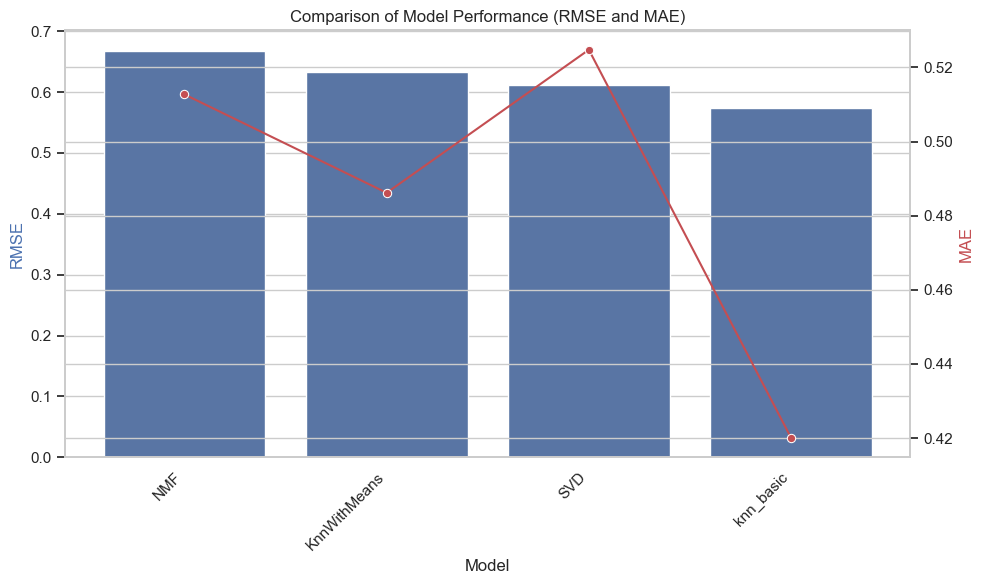

In [27]:
# Now, let's use seaborn to plot the model performance
sns.set(style="whitegrid")
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plotting RMSE values
sns.barplot(x="Model", y="RMSE", data=opt_performance_df, color='b', ax=ax1)
ax1.set_ylabel('RMSE', color='b')

# Creating a twin Y-axis to plot MAE values
ax2 = ax1.twinx()
sns.lineplot(x="Model", y="MAE", data=opt_performance_df, marker='o', color='r', ax=ax2)
ax2.set_ylabel('MAE', color='r')

# Setting the plot title and labels
plt.title('Comparison of Model Performance (RMSE and MAE)')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
plt.tight_layout()

# Display the plot
plt.show()

We can see that KNNBasic Item Based Collaborating Filterting performs the best 

Integrating Restaraunt Clusters from GMM clustering to the best collaborative filtering recommender system 

#### Data Preparation

In [28]:
# Merge ratings with restaurant clusters to find out user's most common cluster
user_cluster_data = pd.merge(ratings, restaraunts[['placeID', 'cluster']], on='placeID')

In [29]:
def get_popularity_based_recommendations(cluster_restaurant_ids, ratings, topk=10):
    # Filter ratings for the given cluster's restaurants
    cluster_ratings = ratings[ratings['placeID'].isin(cluster_restaurant_ids)]
    # Aggregate ratings to find the most popular items
    popularity_scores = cluster_ratings.groupby('placeID')['rating'].mean().sort_values(ascending=False)
    top_items = popularity_scores.head(topk).index.tolist()
    return top_items  # Returns the top-k item IDs


In [30]:
# Function to get the most common cluster for a user
def get_most_common_cluster(user_id, user_cluster_data):
    user_data = user_cluster_data[user_cluster_data['userID'] == user_id]
    if user_data.empty:
        return None  # No data for this user
    return user_data['cluster'].mode()[0]  # Most common cluster for this user

# Assuming 'model' is your trained KNNBasic model with the best parameters
# Here is an example of how to use this in a complete process:
def get_cluster_recommendations(user_id, all_restaurants, user_cluster_data, item_mapper, model, topk=10):
    most_common_cluster = get_most_common_cluster(user_id, user_cluster_data)
    if most_common_cluster is not None:
        # Filter all_restaurants for those in the most common cluster
        cluster_restaurants = all_restaurants[all_restaurants['cluster'] == most_common_cluster]
        cluster_restaurant_ids = cluster_restaurants['placeID'].tolist()
        
        # Get recommendations using the recommend_places function
        return recommend_places(user_id, cluster_restaurant_ids, item_mapper, model, topk)
    else:
        # If user's preferred cluster is not known, provide global popularity-based recommendations
        global_popular_items = get_popularity_based_recommendations(all_restaurants['placeID'].tolist(), ratings, topk)
        # Construct the recommendations DataFrame
        global_popular_recommendations_df = pd.DataFrame({'Restaurant ID': global_popular_items}).merge(all_restaurants[['placeID', 'name']], left_on='Restaurant ID', right_on='placeID', how='left')
        return global_popular_recommendations_df[['Restaurant ID', 'name']].rename(columns={'name': 'Restaurant Name'})

In [31]:
# Example usage:
user_id = 'U1081'  # Replace with an actual user ID
all_restaurants = restaraunts.copy()  # Assuming this is your restaurants DataFrame
top_recommendations = get_cluster_recommendations(user_id, all_restaurants, user_cluster_data, item_mapper, knn_means_final, topk=10)
print(top_recommendations)

    Restaraunt ID                          Restaraunt Name
58         134986                 Restaurant Las Mananitas
31         135034               Michiko Restaurant Japones
53         132755                     La Estrella de Dimas
0          134999                          Kiku Cuernavaca
33         135055  la Cochinita Pibil Restaurante Yucateco
25         132869                            Dominos Pizza
46         135035                     El Mundo de la Pasta
19         135030                 Preambulo Wifi Zone Cafe
62         132754                          Cabana Huasteca
64         135028                              La Virreina
